Inspired/based on https://github.com/rayidghani/magicloops and https://github.com/dssg/MLforPublicPolicy/blob/master/labs/2019/lab6_feature_generation_sol.ipynb

In [1]:
import pipeline_evictions as pipeline
import ml_loop_evictions as loop

import importlib
import datetime
import pandas as pd
import numpy as np

# Read data

In [2]:
importlib.reload(pipeline)

datafile = "data/tracts.csv"

#Read data, parsing year column to date type
data = pd.read_csv(datafile, parse_dates=['year'])

# Basic Cleaning

In [3]:
# Delete rows that do not have eviction-rate. We do not want to impute this value

data.dropna(subset=['eviction-rate'], inplace=True)
data['eviction-rate'].isnull().values.any()
data.reset_index(inplace=True, drop=True)

# Create outcome label

In [4]:
def get_eviction_rate(df, year,geoid):
    
  data_to_return = df.loc[(df['year'] == year) & (df['GEOID'] == geoid)]
  
  if(data_to_return.empty):
    return 0
  
  return data_to_return['eviction-rate'].iloc[0]

In [5]:
importlib.reload(pipeline)

from dateutil.relativedelta import relativedelta

#Obtain eviction-rate cutoff for the top 10%, for each year
cutoff_10_percent={}
for year in range(2000,2017):
    year = pd.Timestamp(year,1,1)
    cutoff_10_percent[year]=data.loc[data['year'] == year]['eviction-rate'].quantile(.9)
    
top_10_eviction_rate_in_any_next_3_years_column = np.zeros(len(data))

#We will take the chance of generating feature 'top 10% last year', which we will mainly used for baseline model
top_10_eviction_rate_last_year_column = np.zeros(len(data))

for index, row in data.iterrows():
  
  #Because the outcome will come from eviction-rate in next 3 years and we have data till 2016,
  #features data bust be from 2013 or before
  
  #We will also limit rows so that they all have one year before them (to calculate to_10_previous_year_feature)
 
  if(row['year']<=pd.Timestamp(2013,1,1) and row['year']>=pd.Timestamp(2001,1,1)):    
    
    found_year_where_eviction_was_in_top_10_percent=0
    
    #Get eviction for the next 3 years
    for i in range(1,4):
      date_in_i_years = row['year'] + relativedelta(years=i)
      eviction_rate_in_i_years = get_eviction_rate(data, date_in_i_years,row['GEOID'])
    
      top_10_eviction_rate_in_i_years = 1 if eviction_rate_in_i_years>= cutoff_10_percent[date_in_i_years] else 0
      

      
      #If we found one year that meets requirement, we are done with looping
      if(top_10_eviction_rate_in_i_years==1):
        found_year_where_eviction_was_in_top_10_percent=1
        break

    top_10_eviction_rate_in_any_next_3_years_column[index]=found_year_where_eviction_was_in_top_10_percent

    
    #Generating feature top 10% last year.
    date_last_years = row['year'] - relativedelta(years=1)
    eviction_rate_last_year = get_eviction_rate(data, date_last_years,row['GEOID'])
    top_10_eviction_rate_last_year = 1 if eviction_rate_last_year>= cutoff_10_percent[date_last_years] else 0

    top_10_eviction_rate_last_year_column[index] = top_10_eviction_rate_last_year
    
    
data['top_10_percent_in_any_next_3_years'] = top_10_eviction_rate_in_any_next_3_years_column

label ='top_10_percent_in_any_next_3_years'

#Append feature top 10% last year
data['top_10_percent_last_year']=top_10_eviction_rate_last_year_column

# Create temporal train and test sets

In [6]:
importlib.reload(pipeline)

#Create sets of train and test data, based on different split thresholds
#The split thresholds corresponds to the starting date of the testing data

#Splits according to https://docs.google.com/spreadsheets/d/1ipqsgThz7hdXXyyNpTuqa4J1inc088lop7lhFsAQ_r0/edit#gid=0
split_thresholds = [pd.Timestamp(i,1,1) for i in range (2005, 2014)]

#Indicating which is the column to be used for splitting training and test data
date_column='year'

#Amount of data used for test set
test_window = relativedelta(years=4)

#Gap needed between training and test set
prediction_horizon = relativedelta(years=3)

#Gap needed for feature generation
feature_generation_gap = relativedelta(years=1)

#Generate train and test sets
train_test_sets= pipeline.create_temp_validation_train_and_testing_sets(
  data,
  date_column,
  label,
  split_thresholds,
  test_window,
  prediction_horizon,
  feature_generation_gap)

# Imputation

In [7]:
importlib.reload(pipeline)

#Impute data on continuous columns for each training and test set

float_columns = [column for column in data.columns if data[column].dtype=='float']

#Do not consider GEOID column nor top_10_percent_in_any_next_3_years
float_columns.remove('name')
float_columns.remove('top_10_percent_in_any_next_3_years')


for train_test_set in train_test_sets:
  train_data = train_test_set['x_train']
  test_data = train_test_set['x_test']

  #fill na values with mean
  pipeline.impute_data(train_data, float_columns)
  pipeline.impute_data(test_data, float_columns)


# Create features

In [8]:
import feature_generation as fg

importlib.reload(pipeline)
importlib.reload(fg)

#We will have to generate features independently for each different train/test set
for train_test_set in train_test_sets:

  train_features = fg.create_features(train_test_set['x_train'])
  test_features = fg.create_features(train_test_set['x_test']) 
  
  #Alternative for just working with default features
  #train_features, test_features = pipeline.create_features(train_test_set)
  
  #Replace raw data in train_test_set with features generated
  #Keep geoid
  train_test_set['x_train'] = train_test_set['x_train']['GEOID'].to_frame().reset_index(drop=True).join(train_features)
  train_test_set['x_test'] = train_test_set['x_test']['GEOID'].to_frame().reset_index(drop=True).join(test_features)
  

# Build Clasifiers and parameters generation

In [9]:
importlib.reload(pipeline)

#We define the specific models we want to run
models_to_run=['Baseline','DT','LR','RF','NB','BA','AB','GB']#,ET,KNN,SVM'

#Get all posible models and their different sets of parameters
models, parameters_grid = pipeline.get_models_and_parameters('small')

# Loop over models and different training/test sets

In [10]:
importlib.reload(pipeline)
importlib.reload(loop)

import warnings
warnings.filterwarnings('ignore')

results = loop.iterate_over_models_and_training_test_sets(models_to_run, models, parameters_grid, train_test_sets)
results

2019-06-12 16:06:08.357978: Running Baseline with params: {} on train/test set 2005-01-01 00:00:00
2019-06-12 16:06:08.593987: Running DT with params: {'min_samples_split': 2, 'criterion': 'gini', 'max_depth': 2} on train/test set 2005-01-01 00:00:00
2019-06-12 16:06:08.764038: Running DT with params: {'min_samples_split': 2, 'criterion': 'gini', 'max_depth': 50} on train/test set 2005-01-01 00:00:00
2019-06-12 16:06:08.948663: Running DT with params: {'min_samples_split': 2, 'criterion': 'gini', 'max_depth': 100} on train/test set 2005-01-01 00:00:00
2019-06-12 16:06:09.129843: Running LR with params: {'penalty': 'l1', 'C': 0.1} on train/test set 2005-01-01 00:00:00
2019-06-12 16:06:14.647509: Running LR with params: {'penalty': 'l2', 'C': 0.1} on train/test set 2005-01-01 00:00:00
2019-06-12 16:06:15.098431: Running LR with params: {'penalty': 'l1', 'C': 10} on train/test set 2005-01-01 00:00:00
2019-06-12 16:06:25.840690: Running LR with params: {'penalty': 'l2', 'C': 10} on train/t

2019-06-12 16:08:16.418440: Running RF with params: {'n_estimators': 1000, 'n_jobs': -1, 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 50} on train/test set 2007-01-01 00:00:00
2019-06-12 16:08:17.863315: Running RF with params: {'n_estimators': 100, 'n_jobs': -1, 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 100} on train/test set 2007-01-01 00:00:00
2019-06-12 16:08:18.286570: Running RF with params: {'n_estimators': 1000, 'n_jobs': -1, 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 100} on train/test set 2007-01-01 00:00:00
2019-06-12 16:08:20.438562: Running NB with params: {} on train/test set 2007-01-01 00:00:00
2019-06-12 16:08:20.604642: Running BA with params: {'n_estimators': 10} on train/test set 2007-01-01 00:00:00
2019-06-12 16:08:21.557640: Running BA with params: {'n_estimators': 100} on train/test set 2007-01-01 00:00:00
2019-06-12 16:08:29.550762: Running AB with params: {'n_estimators': 10, 'algorithm': 'SAMME'} on train/tes

2019-06-12 16:11:25.025627: Running Baseline with params: {} on train/test set 2010-01-01 00:00:00
2019-06-12 16:11:25.217489: Running DT with params: {'min_samples_split': 2, 'criterion': 'gini', 'max_depth': 2} on train/test set 2010-01-01 00:00:00
2019-06-12 16:11:25.417099: Running DT with params: {'min_samples_split': 2, 'criterion': 'gini', 'max_depth': 50} on train/test set 2010-01-01 00:00:00
2019-06-12 16:11:25.800048: Running DT with params: {'min_samples_split': 2, 'criterion': 'gini', 'max_depth': 100} on train/test set 2010-01-01 00:00:00
2019-06-12 16:11:26.179151: Running LR with params: {'penalty': 'l1', 'C': 0.1} on train/test set 2010-01-01 00:00:00
2019-06-12 16:11:30.678363: Running LR with params: {'penalty': 'l2', 'C': 0.1} on train/test set 2010-01-01 00:00:00
2019-06-12 16:11:31.444259: Running LR with params: {'penalty': 'l1', 'C': 10} on train/test set 2010-01-01 00:00:00
2019-06-12 16:12:51.499627: Running LR with params: {'penalty': 'l2', 'C': 10} on train/t

2019-06-12 16:17:33.917487: Running RF with params: {'n_estimators': 1000, 'n_jobs': -1, 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 50} on train/test set 2012-01-01 00:00:00
2019-06-12 16:17:36.966529: Running RF with params: {'n_estimators': 100, 'n_jobs': -1, 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 100} on train/test set 2012-01-01 00:00:00
2019-06-12 16:17:37.621402: Running RF with params: {'n_estimators': 1000, 'n_jobs': -1, 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 100} on train/test set 2012-01-01 00:00:00
2019-06-12 16:17:40.231313: Running NB with params: {} on train/test set 2012-01-01 00:00:00
2019-06-12 16:17:40.419189: Running BA with params: {'n_estimators': 10} on train/test set 2012-01-01 00:00:00
2019-06-12 16:17:42.559559: Running BA with params: {'n_estimators': 100} on train/test set 2012-01-01 00:00:00
2019-06-12 16:18:01.482095: Running AB with params: {'n_estimators': 10, 'algorithm': 'SAMME'} on train/tes

,model_name,model,parameters,test_set_start_date,baseline,p_at_1,r_at_1,f1_at_1,p_at_2,r_at_2,...,p_at_20,r_at_20,f1_at_20,p_at_30,r_at_30,f1_at_30,p_at_50,r_at_50,f1_at_50,auc-roc
0,Baseline,Baseline model,{},2005-01-01,0.140202,0.944444,0.064394,0.120567,0.918919,0.128788,...,0.409574,0.583333,0.481250,0.281915,0.602273,0.384058,0.182784,0.651515,0.285477,0.778655
1,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'min_samples_split': 2, 'criterion': 'gini', ...",2005-01-01,0.140202,0.722222,0.049242,0.092199,0.675676,0.094697,...,0.531915,0.757576,0.625000,0.381206,0.814394,0.519324,0.244421,0.871212,0.381743,0.870593
2,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'min_samples_split': 2, 'criterion': 'gini', ...",2005-01-01,0.140202,0.000000,0.000000,0.000000,0.135135,0.018939,...,0.202128,0.287879,0.237500,0.253546,0.541667,0.345411,0.221041,0.787879,0.345228,0.720829
3,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'min_samples_split': 2, 'criterion': 'gini', ...",2005-01-01,0.140202,0.000000,0.000000,0.000000,0.135135,0.018939,...,0.202128,0.287879,0.237500,0.253546,0.541667,0.345411,0.221041,0.787879,0.345228,0.720829
4,LR,"LogisticRegression(C=10, class_weight=None, du...","{'penalty': 'l1', 'C': 0.1}",2005-01-01,0.140202,0.777778,0.053030,0.099291,0.513514,0.071970,...,0.523936,0.746212,0.615625,0.377660,0.806818,0.514493,0.249734,0.890152,0.390041,0.868135
5,LR,"LogisticRegression(C=10, class_weight=None, du...","{'penalty': 'l2', 'C': 0.1}",2005-01-01,0.140202,0.777778,0.053030,0.099291,0.540541,0.075758,...,0.449468,0.640152,0.528125,0.335106,0.715909,0.456522,0.226355,0.806818,0.353527,0.805510
6,LR,"LogisticRegression(C=10, class_weight=None, du...","{'penalty': 'l1', 'C': 10}",2005-01-01,0.140202,0.833333,0.056818,0.106383,0.864865,0.121212,...,0.486702,0.693182,0.571875,0.358156,0.765152,0.487923,0.246546,0.878788,0.385062,0.833607
7,LR,"LogisticRegression(C=10, class_weight=None, du...","{'penalty': 'l2', 'C': 10}",2005-01-01,0.140202,0.944444,0.064394,0.120567,0.918919,0.128788,...,0.470745,0.670455,0.553125,0.338652,0.723485,0.461353,0.228480,0.814394,0.356846,0.826228
8,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'n_estimators': 100, 'n_jobs': -1, 'max_featu...",2005-01-01,0.140202,1.000000,0.068182,0.127660,1.000000,0.140152,...,0.537234,0.765152,0.631250,0.395390,0.844697,0.538647,0.274176,0.977273,0.428216,0.922165
9,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'n_estimators': 1000, 'n_jobs': -1, 'max_feat...",2005-01-01,0.140202,1.000000,0.068182,0.127660,1.000000,0.140152,...,0.545213,0.776515,0.640625,0.393617,0.840909,0.536232,0.272051,0.969697,0.424896,0.923473


<Figure size 432x288 with 0 Axes>

# Observe best models for each train/test set, for different metrics

In [11]:
importlib.reload(pipeline)

#Lets obtain the best model for each train/test set, for each metric
metrics_to_display = ['p_at_5','p_at_10', 'auc-roc']

best_models_per_metric = {}

for metric in metrics_to_display:
    #indices of rows that have max value in specific metric for each train/test set
    idx = results.groupby(['test_set_start_date'])[metric].transform(max) == results[metric]

    #save table of best models at the specific metric
    best_models_per_metric[metric] = results[idx]

### Best models for Precision at 5%

In [12]:
best_models_per_metric['p_at_5'].iloc[:, [0,2,3,4,11,12,13]]

,model_name,parameters,test_set_start_date,baseline,p_at_5,r_at_5,f1_at_5
10,RF,"{'n_estimators': 100, 'n_jobs': -1, 'max_featu...",2005-01-01,0.140202,0.989362,0.352273,0.519553
12,RF,"{'n_estimators': 100, 'n_jobs': -1, 'max_featu...",2005-01-01,0.140202,0.989362,0.352273,0.519553
24,DT,"{'min_samples_split': 2, 'criterion': 'gini', ...",2006-01-01,0.111524,0.627660,0.280952,0.388158
42,GB,"{'learning_rate': 0.001, 'n_estimators': 10}",2006-01-01,0.111524,0.627660,0.280952,0.388158
43,GB,"{'learning_rate': 0.001, 'n_estimators': 100}",2006-01-01,0.111524,0.627660,0.280952,0.388158
47,DT,"{'min_samples_split': 2, 'criterion': 'gini', ...",2007-01-01,0.154198,0.953846,0.306931,0.464419
54,RF,"{'n_estimators': 100, 'n_jobs': -1, 'max_featu...",2007-01-01,0.154198,0.953846,0.306931,0.464419
75,LR,"{'penalty': 'l1', 'C': 10}",2008-01-01,0.145802,0.938462,0.319372,0.476562
89,GB,"{'learning_rate': 0.001, 'n_estimators': 100}",2008-01-01,0.145802,0.938462,0.319372,0.476562
90,GB,"{'learning_rate': 0.1, 'n_estimators': 10}",2008-01-01,0.145802,0.938462,0.319372,0.476562


### Best models for Precision at 10%

In [13]:
best_models_per_metric['p_at_10'].iloc[:, [0,2,3,4,14,15,16]]

,model_name,parameters,test_set_start_date,baseline,p_at_10,r_at_10,f1_at_10
11,RF,"{'n_estimators': 1000, 'n_jobs': -1, 'max_feat...",2005-01-01,0.140202,0.867021,0.617424,0.721239
13,RF,"{'n_estimators': 1000, 'n_jobs': -1, 'max_feat...",2005-01-01,0.140202,0.867021,0.617424,0.721239
33,RF,"{'n_estimators': 100, 'n_jobs': -1, 'max_featu...",2006-01-01,0.111524,0.569149,0.509524,0.537688
34,RF,"{'n_estimators': 1000, 'n_jobs': -1, 'max_feat...",2006-01-01,0.111524,0.569149,0.509524,0.537688
35,RF,"{'n_estimators': 100, 'n_jobs': -1, 'max_featu...",2006-01-01,0.111524,0.569149,0.509524,0.537688
36,RF,"{'n_estimators': 1000, 'n_jobs': -1, 'max_feat...",2006-01-01,0.111524,0.569149,0.509524,0.537688
56,RF,"{'n_estimators': 100, 'n_jobs': -1, 'max_featu...",2007-01-01,0.154198,0.847328,0.549505,0.666667
58,RF,"{'n_estimators': 100, 'n_jobs': -1, 'max_featu...",2007-01-01,0.154198,0.847328,0.549505,0.666667
73,LR,"{'penalty': 'l1', 'C': 0.1}",2008-01-01,0.145802,0.801527,0.549738,0.652174
77,RF,"{'n_estimators': 100, 'n_jobs': -1, 'max_featu...",2008-01-01,0.145802,0.801527,0.549738,0.652174


### Best models for AUC-ROC

In [14]:
best_models_per_metric['auc-roc'].iloc[:, [0,2,3,4,26]]

,model_name,parameters,test_set_start_date,baseline,auc-roc
11,RF,"{'n_estimators': 1000, 'n_jobs': -1, 'max_feat...",2005-01-01,0.140202,0.928565
13,RF,"{'n_estimators': 1000, 'n_jobs': -1, 'max_feat...",2005-01-01,0.140202,0.928565
34,RF,"{'n_estimators': 1000, 'n_jobs': -1, 'max_feat...",2006-01-01,0.111524,0.885851
36,RF,"{'n_estimators': 1000, 'n_jobs': -1, 'max_feat...",2006-01-01,0.111524,0.885851
66,GB,"{'learning_rate': 0.001, 'n_estimators': 100}",2007-01-01,0.154198,0.916188
80,RF,"{'n_estimators': 1000, 'n_jobs': -1, 'max_feat...",2008-01-01,0.145802,0.925141
82,RF,"{'n_estimators': 1000, 'n_jobs': -1, 'max_feat...",2008-01-01,0.145802,0.925141
109,AB,"{'n_estimators': 10, 'algorithm': 'SAMME'}",2009-01-01,0.146154,0.938359
123,RF,"{'n_estimators': 100, 'n_jobs': -1, 'max_featu...",2010-01-01,0.170803,0.942200
146,RF,"{'n_estimators': 100, 'n_jobs': -1, 'max_featu...",2011-01-01,0.148040,0.941272


### Plot of all model types performance at different train/test sets, for the different metrics

<Figure size 432x288 with 0 Axes>

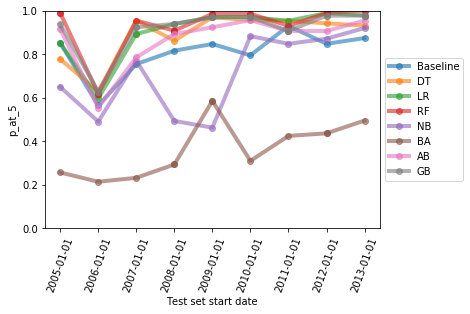

<Figure size 432x288 with 0 Axes>

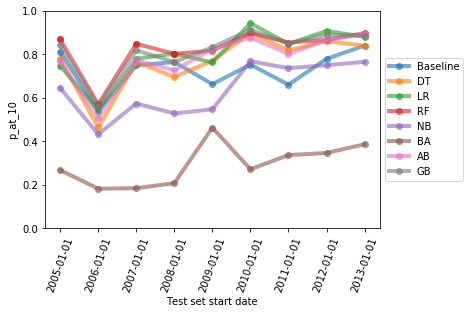

<Figure size 432x288 with 0 Axes>

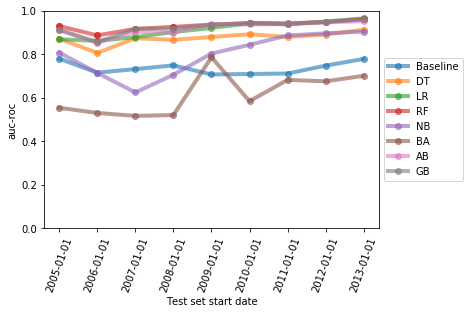

In [15]:
importlib.reload(pipeline)

best_models_per_metric = {}

for metric in metrics_to_display:
    #For each model, find the set of parameters that work the best in each train/test set
    best_models = pipeline.get_best_models_of_each_type_for_each_train_test_set(models_to_run,results,'test_set_start_date', metric)
    pipeline.plot_models_in_time(models_to_run, best_models, metric)
    best_models_per_metric[metric]=best_models
   